# Seminar 3

In lecture you have examined the basics of speech recognition and covered the Connectionist Temporal Classification (CTC) model in detail. You are now ready to train your first "adult" speech recognition system!

In this seminar and homework exercise you will explore speech recongition using Connectionist Temporal Classification (CTC). This seminar and homework are both LARGE and CHALLENGE, so expect to spent a significant amount of time on this. 

In seminar 3 you will implement the CTC forward and backward algorithms in order to calculate the CTC loss and study the diffusion of probability in a CTC trellis. Also you will implement a greedy decoder and a prefix beam-search decoder

## Problem statement

![img](./images/defenition.png)

Define a modified label sequence $\omega'_{1:2L + 1}$:
- add blanks to the beginning and the end of the original label sequence $\omega_{1:L}$
- insert blanks between every pair of labels

<p style="text-align:center;"><img src="./images/doors_with_eps.png" height="150px" width="400px">

Define $\alpha_t(s)$ as the probability of all paths of length $t$ which go through state $\omega_s'$:

Denote a sequence of **acoustic features** or **observations** as

$$
    \mathbf{X}_{1:T} = \{x_1, \ldots, x_T\}
$$

Define a mapping $\mathcal{M}$ between words $\mathbf{w}$ and speech units $\omega_{1:L}$:

$$
    \{\omega^{(q)}_{1:L_q}\}^Q_{q = 1} = \mathcal{M}(\mathbf{w})
$$

$$
    \{\mathbf{w}^{(p)}\}^P_{p = 1} = \mathcal{M}^{-1}(\omega_{1:L})
$$

For some choices of speech units this mapping is not 1-to-1 ($Q > 1$, $P > 1$). A possible pair of text (green) and speech units (yellow):

![img](./images/seq_splitting_example.png)

Automated speech recognition (ASR) is a **discriminative** task $\rightarrow$ "Which sequence $\mathbf{\hat w}$ is likely given the audio?":

$$
    \mathbf{\hat w} = \mathcal{M}^{-1}(\hat \omega_{1:L}), \quad \hat \omega_{1:L} = \arg \max_{\hat \omega_{1: L}} P(\hat \omega_{1:L} | \mathbf{X}_{1: T}; \theta),
$$

where $\theta$ denotes the parameters of the model we are building to solve the problem.

## Discriminative state-space models

How feature vectors $\mathbf{X}_{1: T}$ and speech units $\omega_{1:L}$ relate or **align** to each other? Two common approaches to constructing models which can align:
- state-space models
- neural attention mechanisms

State-space models represent the space of various alignments in the form of a table (called **trellis**), the rows of which correspond to phonemes, and the columns are observed variables. One alignment is the path in this table from the upper left corner to the lower right.

The alignment function $
\mathcal{A}(\omega_{1:L}, T) = \mathbf{\Pi}_{1:T} = \left\{ \pi_{1:T}^{(1)}, \ldots, \pi_{1:T}^{(S)} \right\}_{s=1}^{S} 
$ yields the set of paths through trellis, where $\pi_{1:T}$ is a certain path through trellis. Alignment function can also be interpreted as all paths through our trellis.

![img](./images/trace.png)

Denote a set of all paths in trellis that map onto the phoneme sequence $\omega_{1:L}$ as $\mathcal{A}(\omega_{1:L})$, and let $\pi_{1:T} \in \mathcal{A}(\omega_{1:L})$ be an element of this set. Then a discriminative state-space system models $P(\omega_{1:L} | \mathbf{X}_{1: T}; \theta)$ as 

$$
    P(\omega_{1:L} | \mathbf{X}_{1: T}; \theta) = \sum_{\pi_{1:T} \in \mathcal{A}(\omega_{1:L})} P(\pi_{1:T} | \mathbf{X}_{1:T}; \theta)
$$

Imagine that we have a recurrent neural network parametrized with $\theta$. The network outputs a distribution $P(z_t|x_t; \theta)$ over possible speech units $\omega$ for each frame $x_t$:

![img](./images/rnn.png)

CTC is a discriminative state-space model defined as:
    
$$
    P(\omega_{1:L} | \mathbf{X}_{1: T}; \theta) = \sum_{\pi_{1:T} \in \mathcal{A}(\omega_{1:L})} \prod_{t = 1}^T P(z_t = \pi_t| x_t; \theta)
$$
    
- CTC assumes all states conditionally independent
- Alignment free -- does not need prior alignment for training

# Setup - Install package, download files, etc...

In [1]:
# uncomment if needed. If you run the notebook in Colab, all these libraries are pre-installed
# !pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install numpy==1.17.5 matplotlib==3.3.3 tqdm==4.54.0

In [2]:
# !pip install arpa

In [3]:
%%capture
# !pip install wandb -qqq

In [4]:
# comment out if needed
# !mkdir week_03_files
# !wget -O week_03_files/utils.py https://raw.githubusercontent.com/yandexdataschool/speech_course/refs/heads/2022/week_05/utils.py
# !wget -O week_03_files/test_matrix.txt -q https://raw.githubusercontent.com/yandexdataschool/speech_course/refs/heads/2022/week_05/test_matrix.txt
# !wget -O week_03_files/soft_alignment.txt -q https://raw.githubusercontent.com/yandexdataschool/speech_course/refs/heads/2022/week_05/soft_alignment.txt
# !wget -O week_03_files/test_decode.txt -q https://raw.githubusercontent.com/yandexdataschool/speech_course/refs/heads/2022/week_05/test_decode.txt
# !wget -O week_03_files/test_labels.txt -q https://raw.githubusercontent.com/yandexdataschool/speech_course/refs/heads/2022/week_05/test_labels.txt
# !wget -O week_03_files/3-gram.pruned.1e-7.arpa -q https://raw.githubusercontent.com/yandexdataschool/speech_course/refs/heads/2022/week_05/3-gram.pruned.1e-7.arpa

In [5]:
#!L
import math
import os
import shutil
import string
import time
from collections import defaultdict
from typing import List, Tuple, TypeVar, Optional, Callable, Iterable

import arpa
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import wandb
from matplotlib.colors import LogNorm
from torch import optim
from tqdm.notebook import tqdm

In [6]:
import utils as utils   # Change relative path if needed

# Seminar 3: CTC Forward-Backward Algorithm

1. Implement a Forward
2. Implement a Backward
3. Implement soft alignment

## Theoretical Recap

### Forward Algorithm

$$
    \large{\alpha_t(s) = P(\omega_{1:s/2}, \pi_t = \omega_s' | \mathbf{X}_{1:T}, \theta) = \sum_{\pi_{1:t - 1} \in \mathcal{A}(\omega_{1:s/2}), \, \pi_t = \omega_s'}  P(\pi_{1:t} | \mathbf{X}_{1:T}, \theta)}
$$

Note that despite the fact that we have moved to the extended sequence $\omega'$, we are still interested in maximizing the probability of alignments to the original sequence. And step $s$ in the new sequence corresponds to step $s/2$ in the old sequence (rounded to the bottom).

The CTC forward algorithm recursively computes the forward variable $\alpha_t(s)$.

![img](./images/ctc_forward.png)


**Initialization.** We allow all prefixes to start with either a blank ($\epsilon$) or the first symbol in $\omega_{1:L}$. Also note that $\alpha_t(s) = 0,\ \forall s < (2L + 1) - 2(T - t) - 1$, because these variables correspond to states for which there are not enough time-steps left to complete the sequence.

This gives us the following rules for initialization:

$$\Large
  \begin{aligned}
    &\alpha_t(0) = 0, \forall t & \\
    &\alpha_1(1) = P(z_1 = \epsilon | \mathbf{X}_{1:T}), &\\
    &\alpha_1(2) = P(z_1 = \omega^{'}_2 | \mathbf{X}_{1:T}), &\\
    &\alpha_1(s) = 0,\ \forall s > 2 &\\
    &\alpha_t(s) = 0,\ \forall s < (2L + 1) - 2(T - t) - 1 &  \text{top right zeros}\\
  \end{aligned}
$$

**Recursion.** 

$$\large
  \begin{aligned}
    &\alpha_t(s) = \left \{
  \begin{aligned}
    &\big(\alpha_{t-1}(s) + \alpha_{t-1}(s-1) \big) P(z_t = \omega^{'}_s | \mathbf{X}_{1:T}) & \text{if}\ \omega_s^{'} = \epsilon\ \text{or}\
    \omega_s^{'} = \omega_{s-2}^{'} \\
    &\big(\alpha_{t-1}(s) + \alpha_{t-1}(s-1) + \alpha_{t-1}(s-2)\big) P(z_t = \omega^{'}_s | \mathbf{X}_{1:T}) & \text{otherwise}\\
  \end{aligned} \right. 
  \end{aligned}
$$


![img](./images/ctc_forward_details.png)

### Backward Algorithm

Define $\beta_t(s)$ as the probability of all valid alignments $\omega'_{s:L}$ starting in state $\omega_s'$:

$$
    \beta_t(s) = P(\omega_{s/2:L}, \pi_t = \omega'_s | \mathbf{X}_{1:T}, \theta) = \sum_{\pi_{t + 1:T} \in \mathcal{A}(\omega_{s/2:L}), \, \pi_t = \omega_s'} P(\pi_{t + 1:T} | \mathbf{X}_{1:T}, \theta)
$$

The CTC backward algorithm recursively computes the backward variable $\beta_t(s)$:

![img](./images/ctc_backward.png)



The formulas for backward algorithm are as follows:

$$
  \begin{aligned}
    &\beta_T(2L+1) = 1 &\\
    &\beta_T(2L) = 1 & \\
    &\beta_T(s) = 0, \forall s < 2L &\\
    &\beta_t(s) = 0,\ \forall s > 2t &\\
    &\beta_t(2L+2) = 0,\ \forall t  & \text{bottom left zeros} \\
    &\beta_t(s) = \left \{
  \begin{aligned}
    &\big(\beta_{t+1}(s) + \beta_{t+1}(s+1) \big) P(z_t = \omega^{'}_s | \mathbf{X}_{1:T}) & \text{if}\ \omega_s^{'} = \epsilon\ \text{or}\
    \omega_s^{'} = \omega_{s+2}^{'} \\
    &\big(\beta_{t+1}(s) +\beta_{t+1}(s+1) + \beta_{t+1}(s+2)\big) P(z_t = \omega^{'}_s | \mathbf{X}_{1:T}) & \text{otherwise}\\
  \end{aligned} \right. 
  \end{aligned}
$$

![img](./images/ctc_backward_details.png)

### Alignment and Loss Computation

Use your newfound knowledge of the CTC forward-backward algorithm to obtain a soft-alignment

Remember, that the forward variable is computed as follows:

The probability of all paths passing through a state $\pi_t = \omega_s'$ is the product of forward and backward variables:

$$
    \alpha_t(s) \beta_t(s) = \sum_{\pi_{1:T} \in \mathcal{A}(\omega_{1:L}), \,\pi_t=\omega_s'} P(\pi_{1:T} | \mathbf{X}_{1:T}, \theta)
$$

Then, for any $t$, sum of all such products yields total probability:

$$
     \sum_{s = 1}^{2 L + 1} \alpha_t(s) \beta_t(s) = P(\omega_{1:L} | \mathbf{X}_{1:T}, \theta)
$$

We can also use normalized $\alpha_t(s) \beta_t(s)$ as a measure of **soft-alignment**:

$$
    \text{align}_t(s) = \frac{\alpha_t(s) \beta_t(s)}{\sum_{s = 1}^{2 L + 1} \alpha_t(s) \beta_t(s)}
$$

You should get something like

![img](./images/path_distribution.png)

$$
  \text{align}_t(s) = \frac{\alpha_t(s)\beta_t(s)}{\sum_{s}\alpha_t(s)\beta_t(s)}
$$


Doing the computation in probability space can be numerically unstable, so you should do it in Log-Space using the
provided logsumexp operation. Remember to return to prob space at the end. 

## Implement CTC Forward Algorithm

In [7]:
# Helper functions
BLANK_SYMBOL = "_"

class Tokenizer:
    """
    Maps characters to integers and vice versa
    """
    def __init__(self):
        self.char_map = {}
        self.index_map = {}
        for i, ch in enumerate(["'", " "] + list(string.ascii_lowercase) + [BLANK_SYMBOL]):
            self.char_map[ch] = i
            self.index_map[i] = ch
        
    def text_to_indices(self, text: str) -> List[int]:
        return [self.char_map[ch] for ch in text]

    def indices_to_text(self, labels: List[int]) -> str:                                                                                                                                                                                                                                 
        return "".join([self.index_map[i] for i in labels])
    
    def get_symbol_index(self, sym: str) -> int:
        return self.char_map[sym]
    

tokenizer = Tokenizer()

NEG_INF = -float("inf")


def logsumexp(*args) -> float:
    """
    Log-sum-exp trick for log-domain calculations
    See for details: https://en.wikipedia.org/wiki/LogSumExp
    """
    if all(a == NEG_INF for a in args):
        return NEG_INF
    a_max = max(args)
    lsp = math.log(sum(math.exp(a - a_max) for a in args))
    return a_max + lsp


def modify_sequence(sequence: List[int], blank_idx: int) -> List[int]:
    """
    Modifies sequence which with START, END blanks and between each character
    """
    modified_sequence = []
    
    for idx in sequence:
        modified_sequence += [blank_idx, idx]
        
    modified_sequence.append(blank_idx)
    return modified_sequence

In [8]:
# Test your implementation

# Load numpy matrix, add axis [classes,time]
matrix = np.loadtxt('files/test_matrix.txt')

# Create label_sequence
labels_indices = tokenizer.text_to_indices('there se ms no good reason for believing that twillc ange')

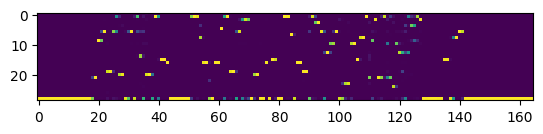

In [9]:
plt.imshow(matrix)
plt.show()

In [10]:
#!L

def forward_algorithm(sequence: List[int], matrix: np.ndarray) -> np.ndarray:
    """
    :param sequence: a string converted to an index array by Tokenizer
    :param matrix: A matrix of shape (K, T) with probability distributions over phonemes at each moment of time.
    :return: the result of the forward pass of shape (2 * len(sequence) + 1, T)
    """
    # Turn probs into log-probs
    matrix = np.log(matrix)
    
    blank = tokenizer.get_symbol_index(BLANK_SYMBOL)
    mod_sequence = modify_sequence(sequence, blank)

    # Initialze
    # (2L + 1) x T 
    alphas = np.full([len(mod_sequence), matrix.shape[1]], NEG_INF)

    for t in range(matrix.shape[1]):
        for s in range(len(mod_sequence)):
            # First Step
            ch = mod_sequence[s]
            if t == 0:
                if s != 0 and s != 1:
                    alphas[s][t] = NEG_INF
                else:
                    alphas[s][t] = matrix[ch][t]
                
            # Upper diagonal zeros
            elif s < alphas.shape[0] - 2 * (alphas.shape[1]-t)-1:# CONDITION
                alphas[s][t] = NEG_INF
            else:
                # Need to do this stabily
                if s == 0:
                    alphas[s][t] = alphas[s][t-1] + matrix[ch][t]
                elif s == 1:
                    alphas[s][t] = logsumexp(alphas[s][t-1], alphas[s-1][t-1]) + matrix[ch][t]
                else:
                    if ch == blank or ch == mod_sequence[s-2]:
                        alphas[s][t] = logsumexp(alphas[s][t-1], alphas[s-1][t-1]) + matrix[ch][t]
                    else:
                        alphas[s][t] = logsumexp(alphas[s][t-1], alphas[s-1][t-1], alphas[s-2][t-1]) + matrix[ch][t]
    return alphas

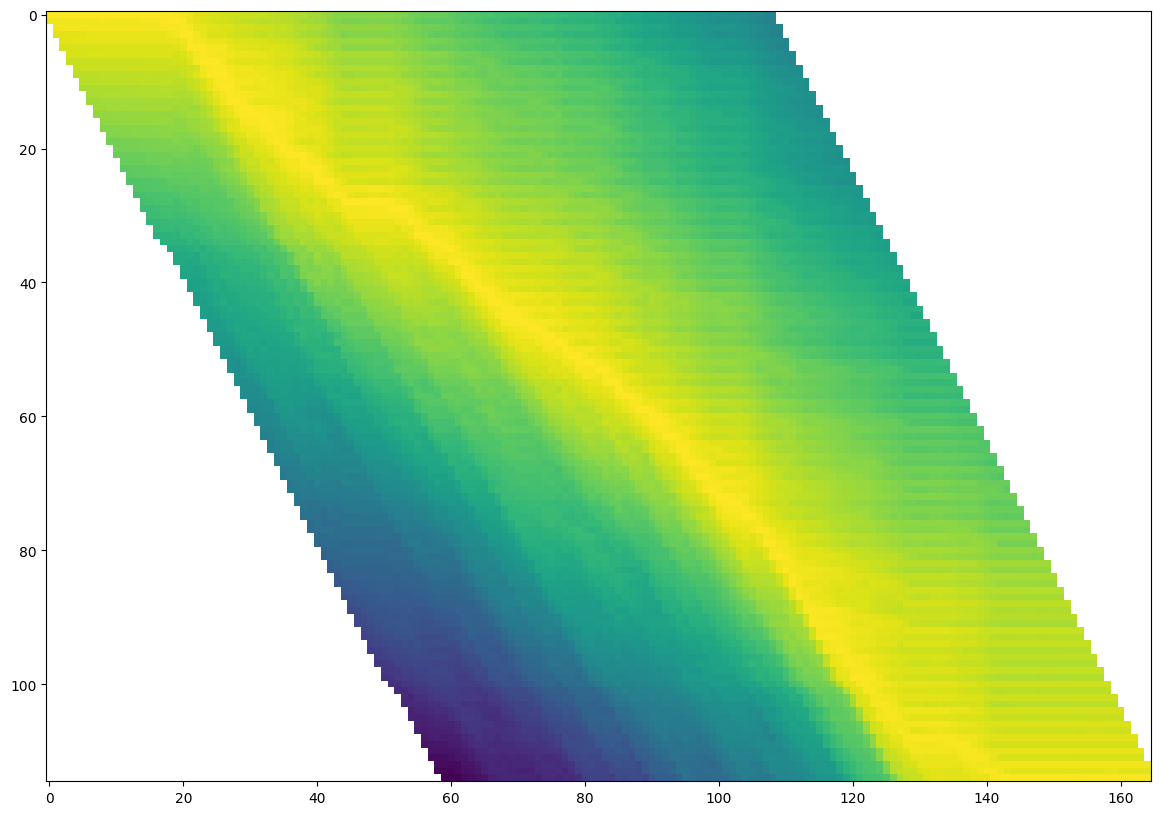

In [11]:
f = forward_algorithm(labels_indices, matrix)
plt.figure(figsize=(16, 10))
plt.imshow(f)
plt.show()

## Implement The CTC Backward Algorithm

In [12]:
def backward_algorithm(sequence: List[int], matrix: np.ndarray) -> np.ndarray:
    """
    :param sequence: a string converted to an index array by Tokenizer
    :param matrix: A matrix of shape (K, T) with probability distributions over phonemes at each moment of time.
    :return: the result of the backward pass of shape (2 * len(sequence) + 1, T)
    """
    matrix = np.log(matrix)
    blank = tokenizer.get_symbol_index(BLANK_SYMBOL)
    mod_sequence = modify_sequence(sequence, blank)
    betas = np.full([len(mod_sequence), matrix.shape[1]], NEG_INF)

    for t in reversed(range(matrix.shape[1])):
        for s in reversed(range(len(mod_sequence))):
            # First Step
            ch = mod_sequence[s]
            if t == matrix.shape[1] - 1:
                if s == betas.shape[0]-1 or s == betas.shape[0]-2:
                    betas[s][t] = 0

            # Lower Diagonal Zeros
            elif s > 2 * t + 1:# CONDITION
                betas[s][t] = NEG_INF
            else:
                if s == len(mod_sequence) - 1:
                    betas[s][t] = betas[s][t+1] + matrix[ch][t]
                elif s == len(mod_sequence) - 2:
                    betas[s][t] = logsumexp(betas[s][t+1], betas[s+1][t+1]) + matrix[ch][t]
                else:
                    if ch == blank or ch == mod_sequence[s + 2]:
                            betas[s][t] = logsumexp(betas[s][t+1], betas[s+1][t+1]) + matrix[ch][t]
                    else:                
                        betas[s][t] = logsumexp(betas[s][t+1], betas[s+1][t+1], betas[s+2][t+1]) + matrix[ch][t]
    return betas

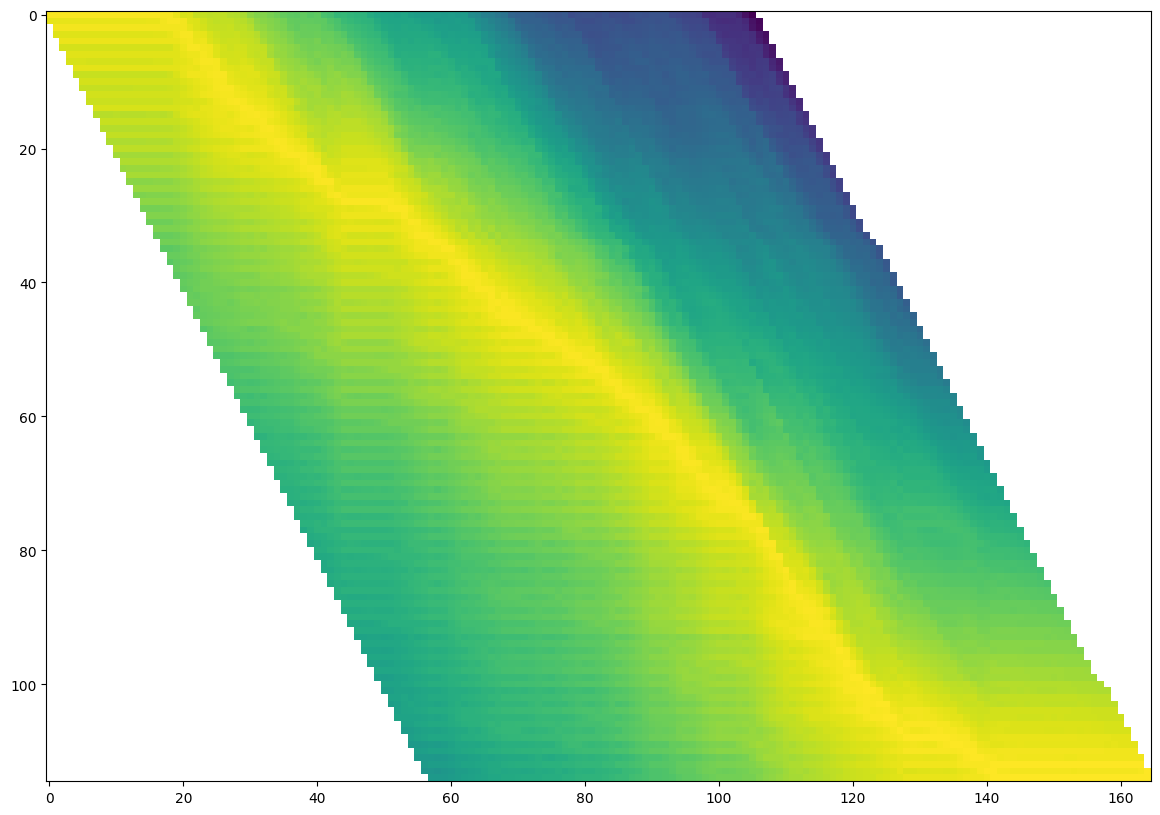

In [13]:
b = backward_algorithm(labels_indices, matrix)
plt.figure(figsize=(16, 10))
plt.imshow(b)
plt.show()

## Obtain Soft-Alignment


In [14]:
def soft_alignment(labels_indices: List[int], matrix: np.ndarray) -> np.ndarray:
    """
    Returns the alignment coefficients for the input sequence
    """
    alphas = forward_algorithm(labels_indices, matrix)
    betas = backward_algorithm(labels_indices, matrix)

    # Move from log space back to prob space
    align = np.exp(alphas + betas)

    # Normalize Alignment
    align = align / np.sum(align, axis=0)

    return align

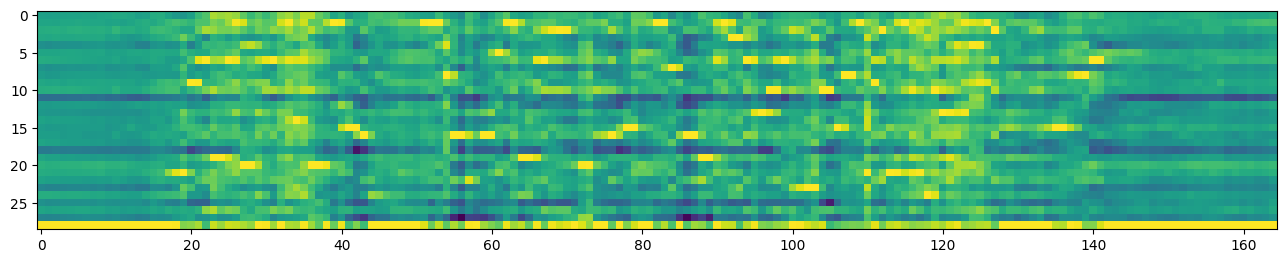

In [15]:
plt.figure(figsize=(16, 10))
plt.imshow(np.log(matrix))
plt.show()

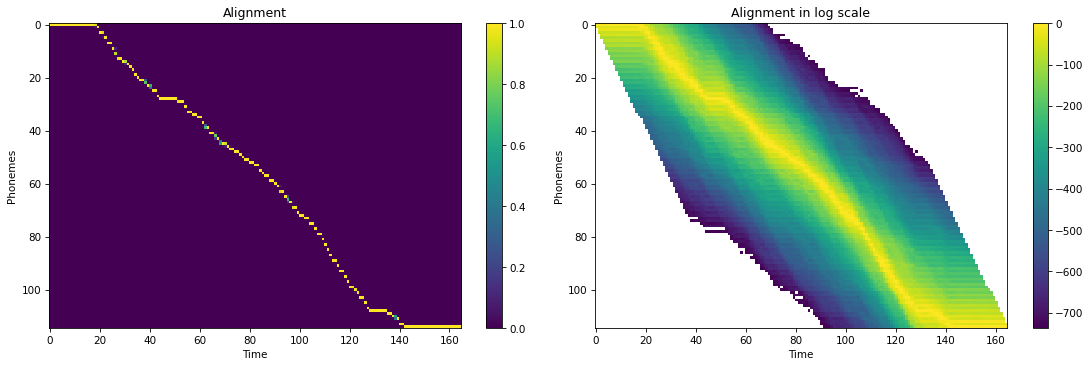

In [17]:
align = soft_alignment(labels_indices, matrix)
f, ax = plt.subplots(1, 2, dpi=75, figsize=(15, 5))


im = ax[0].imshow(align, aspect='auto', interpolation='nearest')
ax[0].set_title("Alignment")
ax[0].set_ylabel("Phonemes")
ax[0].set_xlabel("Time")
f.colorbar(im, ax=ax[0])

im = ax[1].imshow(np.log(align), aspect='auto', interpolation='nearest')
ax[1].set_title("Alignment in log scale")
ax[1].set_ylabel("Phonemes")
ax[1].set_xlabel("Time")
f.colorbar(im, ax=ax[1])

plt.tight_layout()

ref_align = np.loadtxt('files/soft_alignment.txt')
assert np.allclose(ref_align, align)

## Implementing a Decoder

Before you can start having fun with a CTC ASR model, you first need to make sure that you can correctly "decode" or generate text from a working model. This can be done in two ways - using a Greedy Decoder, which is simple and fast, or using a Prefix Beam Search decoder, which is slower, but takes advantages of the fact that multiple plath though a CTC trellis can map to the sample sentence. In the following exercise you will implement both decoders.

### Implement a Greedy Best-Path Decoder!

After we’ve trained the model, we’d like to use it to find a likely output for a given input. Your goal is to implement a Greedy Best-Path decoder. Remember than in CTC the joint distribution over states factors out into a product of marginals:

$${\tt P}(\mathbf{z}_{1:T}|\mathbf{X}_{1:T},\mathbf{\theta}) = \prod_{t = 1}^T{\tt P}(z_t|\mathbf{X}_{1:T},\mathbf{\theta})$$

We can take the most likely output at each time-step, which gives us the alignment with the highest probability:

$$\mathbf{\pi}^*_{1:T} = \arg \max_{\mathbf{\pi}_{1:T} } \prod_{t=1}^T {\tt P}(z_t = \pi_t|\mathbf{X}_{1:T})$$

Then merge repeats and remove blanks.

In [18]:
#!L
def greedy_decoder(output: torch.Tensor, labels: List[torch.Tensor], 
                   label_lengths: List[int], collapse_repeated: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """
    :param output: torch.Tensor of Probs or Log-Probs of shape [batch, time, classes]
    :param labels: list of label indices converted to torch.Tensors
    :param label_lengths: list of label lengths (without padding)
    :param collapse_repeated: whether the repeated characters should be deduplicated
    :return: the result of the decoding and the target sequence
    """
    blank_label = tokenizer.get_symbol_index(BLANK_SYMBOL)

    # Get max classes
    ########################
    arg_maxes = output.argmax(dim=-1)
    ########################

    decodes = []
    targets = []

    # For targets and decodes remove repeats and blanks
    for i, args in enumerate(arg_maxes):
        decode = []
        true_labels = labels[i][:label_lengths[i]].tolist()
        targets.append(tokenizer.indices_to_text(true_labels))

        # Remove repeats, then remove blanks
        for j, index in enumerate(args):
            ########################
            if j != 0:
                if index == args[j-1]:
                    continue
            decode.append(int(index.cpu().detach()))    
            ########################
        ####
        decode = [x for x in decode if x != blank_label]
        ######
        
        decodes.append(tokenizer.indices_to_text(decode))
    return decodes, targets

In [19]:
#!L
# TESTING THE GREEDY DECODER

# Load numpy matrix, make its shape be in the form of [batch, classes, time]
matrix = np.loadtxt('files/test_matrix.txt')[np.newaxis, :, :]

# Turn into Torch Tensor of shape [batch, time, classes]
matrix = torch.Tensor(matrix).transpose(1, 2)

# Convert indices into torch.Tensor
labels_indices = torch.Tensor(tokenizer.text_to_indices('there seems no good reason for believing that it will change'))

# Run the Decoder
decodes, targets = greedy_decoder(matrix, [labels_indices], [len(labels_indices)])

assert decodes[0] == 'there se ms no good reason for believing that twillc ange'
assert targets[0] == 'there seems no good reason for believing that it will change'

### Implement Prefix Decoding With LM

The greedy decoder doesn't take into account the fact that a single output can have many alignments. For example, imagine that the true label for a phoneme sequence is $[a]$. Assume that alignments $[a, a, \epsilon]$ and $[a, a, a]$ individually have lower probability than the probability $[b, b, b]$, but the sum of their probabilities is higher. In this case, the greedy decoder would choose the wrong alignment $[b, b, b]$ and propose a wrong hypothesis $[b]$ instead of $[a]$.

Prefix decoding considers probabilities of multiple paths and merges them. It can also add external language model.

![img](./images/beam_search_alg.png)

[(picture source)](https://distill.pub/2017/ctc/)

Prefix decoding algorithm has 3 nested loops:
- over time - we extend prefixes up to T times
- over prefixes in the beam
- over possible extensions of a prefix

Each prefix can be extended in three possible ways:
- with a blank
- with a repeating character
- with a non-repeating character

We must keep track of two probabilities per prefix:
- The probability of prefix ending with blank $P_b(t, s)$. 
- The probability of prefix not ending with blank $P_{nb}(t, s)$

Here $t$ denotes time step and $s$ denotes a prefix we got after $t$ time steps.

We start with an empty string prefix: 

$$
    P_b(0, \text{""}) = 1
$$
$$
    P_{nb}(0, \text{""}) = 0
$$

If we extend $s$ with a blank, update the probability of ending with a blank:

$$
    P_b(t, s) = P_b(t, s) + P(\epsilon | x_t) \cdot (P_b(t - 1, s) + P_{nb}(t - 1, s))
$$

The prefix $s$ is not updated because blanks are eliminated in the end.

If we extend with a repeat character $c$, there are two options:
1. The previous symbol is a blank, and now we extend the prefix
2. The previous symbol is not a blank, so we don't extend the prefix (repeats are merged)

In this case, the probability $P_{nb}$ is updated as follows:

$$
    P_{nb}(t, s + c) = P_{nb}(t, s + c) + P(c | x_t) \cdot P_b(t - 1, s)
$$
$$
    P_{nb}(t, s) = P_{nb}(t, s) + P(c | x_t) \cdot P_{nb}(t - 1, s)
$$

Finally, consider extending $s$ at time $t$ with a non-repeat character. It can follow both blank and non-blank characters, so the probability $P_{nb}$ is updated as follows:

$$
    P_{nb}(t, s + c) = P_{nb}(t, s + c) + P(c | x_t) \cdot (P_b(t - 1, s) + P_{nb}(t - 1, s))
$$

We may also want to apply a language model during decoding, but only in the case we have a new complete word. This happens when the current symbol is a non-repeat space. As CTC is a discriminative model, LMs can only be integrated as a heuristic:

$$
    \mathbf{w}^* = \arg \max_\mathbf{w} \underbrace{P(\mathbf{w} | \mathbf{X}_{1:T})}_{\text{CTC prob}} \cdot \underbrace{P(\mathbf{w})^{\alpha}}_{\text{LM prob}} \cdot \underbrace{|\mathbf{w}|^\beta}_{\text{Length correction}}
$$

The formula for an update of $P_{nb}$ when LM is used and the current symbol is a non-repeat space:

$$
    P_{nb}(t, s + c) = P_{nb}(t, s + c) + P_{\text{LM}}(s)^\alpha \cdot |s|^\beta \cdot P(c | x_t) \cdot (P_b(t - 1, s) + P_{nb}(t - 1, s))
$$

In [20]:
LanguageModel = TypeVar("LanguageModel")
# Helper function

class Beam:
    def __init__(self, beam_size: int) -> None:
        self.beam_size = beam_size
        
        fn = lambda : (NEG_INF, NEG_INF)
        
        # Store probs key - prefix, value - p_blank, p_not_blank for ? step
        self.candidates = defaultdict(fn)
        
        # Store sorted by cumulative probability self.candidates
        self.top_candidates_list = [
            (
                tuple(), 
                (0.0, NEG_INF) # log(p_blank) = 0, log(p_not_blank) = -inf
            )
        ]
        
    def get_probs_for_prefix(self, prefix: Tuple[int]) -> Tuple[float, float]:
        p_blank, p_not_blank = self.candidates[prefix]
        return p_blank, p_not_blank
        
    def update_probs_for_prefix(self, prefix: Tuple[int], next_p_blank: float, next_p_not_blank: float) -> None:
        self.candidates[prefix] = (next_p_blank, next_p_not_blank)
        
    def update_top_candidates_list(self) -> None:
        top_candidates = sorted(
            self.candidates.items(), 
            key=lambda x: logsumexp(*x[1]), 
            reverse=True
        )
        self.top_candidates_list = top_candidates[:self.beam_size]
        

def calculate_probability_score_with_lm(lm: LanguageModel, prefix: str) -> float:
    text = tokenizer.indices_to_text(prefix).upper().strip()    # Use upper case for LM and remove the trailing space
    lm_prob = lm.log_p(text)             
    score = lm_prob / np.log10(np.e)    # Convert to natural log, as ARPA LM uses log10   
    return score

In [21]:
#!L

def decode(probs: np.ndarray, beam_size: int = 5, lm: Optional[LanguageModel] = None, 
           prune: float = 1e-5, alpha: float = 0.1, beta: float = 2):
    """
    :param probs: A matrix of shape (T, K) with probability distributions over phonemes at each moment of time.
    :param beam_size: the size of beams
    :lm: arpa language model
    :prune: the minimal probability for a symbol at which it can be added to a prefix
    :alpha: the parameter to de-weight the LM probability
    :beta: the parameter to up-weight the length correction term
    :return: the prefix with the highest sum of probabilites P_blank and P_not_blank
    """
    T, S = probs.shape
    probs = np.log(probs)
    blank = tokenizer.get_symbol_index(BLANK_SYMBOL)
    space = tokenizer.get_symbol_index(" ")
    prune = NEG_INF if prune == 0.0 else np.log(prune)
    
    beam = Beam(beam_size)
    # Итерируемся по оси времени
    for t in range(T):
        next_beam = Beam(beam_size)
        
        # Итерируемся по символам
        for s in range(S):
            p = probs[t, s]
            # Prune the vocab - пропускаем символ, если вероятность оказаться в нем слишком мала на t-м щаге
            if p < prune:   
                continue
            
            # Итерируемся по варинатам, в которые можем пойти из текущего символа
            # Сначала идут наиболее вероятные по сумме log(p_blank + p_not_blank) префиксы
            # (p_blank, p_not_blank) - вероятности на предыдущем t-1 шаге
            for prefix, (p_blank, p_not_blank) in beam.top_candidates_list:
                # Текущий символ - бланк 
                if s == blank:
                    # вероятности на текущем шаге
                    p_b, p_nb = next_beam.get_probs_for_prefix(prefix)
                    next_beam.update_probs_for_prefix(
                        prefix=prefix,
                        next_p_blank=logsumexp(p_b, p_blank + p, p_not_blank + p),
                        next_p_not_blank=p_nb
                    )
                    continue

                end_t = prefix[-1] if prefix else None
                n_prefix = prefix + (s,)
                
                # Повторяющийся символ
                if s == end_t:
                    # Предыдущий символ - бланк
                    p_b, p_nb = next_beam.get_probs_for_prefix(n_prefix)
                    next_beam.update_probs_for_prefix(
                        prefix=n_prefix,
                        next_p_blank=p_b,
                        next_p_not_blank=logsumexp(p_nb, p + p_blank)
                    )
                    # Предудщий символ не бланк
                    p_b, p_nb = next_beam.get_probs_for_prefix(prefix)
                    next_beam.update_probs_for_prefix(
                        prefix=prefix,
                        next_p_blank=p_b,
                        next_p_not_blank=logsumexp(p_nb, p + p_not_blank)
                    )
                elif s == space and end_t is not None and lm is not None:
                    # Символ - пробел и не первый, нужно применить языковую модель
                    p_b, p_nb = next_beam.get_probs_for_prefix(n_prefix)
                    score = calculate_probability_score_with_lm(lm, n_prefix)
                    length = len(tokenizer.indices_to_text(prefix))
                    
                    next_beam.update_probs_for_prefix(
                        prefix=n_prefix,         
                        next_p_blank=p_b,
                        next_p_not_blank=logsumexp(
                            p_nb,
                            p_blank + p + score * alpha + np.log(length) * beta,
                            p_not_blank + p + score * alpha + np.log(length) * beta
                        )  
                    )
                else:
                    p_b, p_nb = next_beam.get_probs_for_prefix(n_prefix)
                    next_beam.update_probs_for_prefix(
                        prefix=n_prefix,
                        next_p_blank=p_b,
                        next_p_not_blank=logsumexp(p_nb, p_blank + p, p_not_blank + p)
                    )

        next_beam.update_top_candidates_list()
        beam = next_beam

    best = beam.top_candidates_list[0]
    return best[0], -logsumexp(*best[1])


def beam_search_decoder(probs: np.ndarray, labels: List[List[int]], label_lengths: List[int], 
                        input_lengths: List[int], lm: LanguageModel, beam_size: int = 5,
                        prune: float = 1e-3, alpha: float = 0.1, beta: float = 0.1):
    probs = probs.cpu().detach().numpy()
    decodes, targets = [], []
    
    for i, prob in enumerate(probs):
        targets.append(tokenizer.indices_to_text(labels[i][:label_lengths[i]].tolist()))
        int_seq, _ = decode(prob[:input_lengths[i]], lm=lm, beam_size=beam_size, prune=prune, alpha=alpha, beta=beta)
        decodes.append(tokenizer.indices_to_text(int_seq))
        
    return decodes, targets

In [22]:
# Create LM
alm = arpa.loadf('week_03_files/3-gram.pruned.1e-7.arpa')[0]
alm._unk = '<UNK>'

In [23]:
# TESTING PREFIX Decoder

# Load numpy matrix, add axis [batch, classes, time]
matrix = np.loadtxt('files/test_matrix.txt')[np.newaxis, :, :]

# Turn into Torch Tensor of shape [batch, time, classes]
matrix = torch.Tensor(matrix).transpose(1, 2)

labels_indices = torch.Tensor(tokenizer.text_to_indices('there seems no good reason for believing that it will change'))

# Run the Decoder
decodes, targets = beam_search_decoder(
    matrix, [labels_indices], [len(labels_indices)], [matrix.size()[1]], 
    lm=None, beam_size=5, prune=1e-3, alpha=0.1, beta=0.3
)
assert decodes[0] == 'there se ms no good reason for believing that twil c ange'
# assert decodes[0] == 'thearese ms no good reason for believving that twil c ange'
assert targets[0] == 'there seems no good reason for believing that it will change'

decodes, targets = beam_search_decoder(
    matrix, [labels_indices], [len(labels_indices)], [matrix.size()[1]], 
    lm=alm, beam_size=5, prune=1e-3, alpha=0.1, beta=0.3
)
assert decodes[0] == 'there seems no good reason for believing that twil c ange'
assert targets[0] == 'there seems no good reason for believing that it will change'